Must be run on the GPU

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from functools import partial
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

#rescale the mnist image 28*28 into a 7*7 image
downscale_transform = transforms.Compose([
    transforms.Resize((7,7)),
    transforms.ToTensor()
])

We need to make a custome dataset containing the downscaled input, the regular scale target, and the label

In [ ]:
def modifyDataset(data, target):
    tab = []
    for i in range(len(data)):
        tab.append([data[i][0], target[i][0], data[i][1]])
    return tab  

In [ ]:
MNIST_train_downscale_dataset = datasets.MNIST(
    root      = '../data',
    train     = True,
    download  = True,
    transform = downscale_transform
)

MNIST_test_downscale_dataset = datasets.MNIST(
    root      = '../data',
    train     = False,
    download  = True,
    transform = downscale_transform
)

MNIST_train_dataset = datasets.MNIST(
    root      = '../data',
    train     = True,
    download  = True,
    transform = transform
)

MNIST_test_dataset = datasets.MNIST(
    root      = '../data',
    train     = False,
    download  = True,
    transform = transform
)

MNIST_train = modifyDataset(MNIST_train_downscale_dataset, MNIST_train_dataset)
MNIST_test = modifyDataset(MNIST_test_downscale_dataset, MNIST_test_dataset)

Bonus 1, we use Fashion MNIST dataset

In [ ]:
FashionMNIST_train_downscale_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = True,
    download  = True,
    transform = downscale_transform
)

FashionMNIST_test_downscale_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = False,
    download  = True,
    transform = downscale_transform
)

FashionMNIST_train_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = True,
    download  = True,
    transform = transform
)

FashionMNIST_test_dataset = datasets.FashionMNIST(
    root      = '../data',
    train     = False,
    download  = True,
    transform = transform
)

FashionMNIST_train = modifyDataset(FashionMNIST_train_downscale_dataset, FashionMNIST_train_dataset)
FashionMNIST_test = modifyDataset(FashionMNIST_test_downscale_dataset, FashionMNIST_test_dataset)

In [ ]:
"""
Convolution block, using dropout to improve the training and reduce the overfiting
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3,
                 stride = 1, padding = 1, act = F.relu, drop = 0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels  = in_channels,
            out_channels = out_channels,
            kernel_size  = kernel_size,
            stride       = stride,
            padding      = padding,
        )
        self.act = act
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.dropout(x)

        return x

To increase the resolution of an image we will use the folowing layer, using a ConvTranspose2d layer.

for a tensor :

shape(batch_size, channels, height, width)

the ouptput will be :

shape(batch_size, channels, height * stride - (stride - kernel_size), width * stride - (stride - kernel_size))

In [ ]:
class ConvUpsample(nn.Module):
    """
    this class multiply by 2 the size of tensor in every dimension
    """
    def __init__(self, in_channels, out_channels, kernel_size = 2,
                 stride = 2, padding = 0, act = F.relu, drop = 0):
        super(ConvUpsample, self).__init__()
        self.ct = nn.ConvTranspose2d(
            in_channels  = in_channels,
            out_channels = out_channels,
            kernel_size  = kernel_size,
            stride       = stride,
            padding      = padding,
        )
        self.dropout = nn.Dropout(drop)
        self.act = act

    def forward(self, x):
        x = self.ct(x)
        x = self.act(x)
        x = self.dropout(x)

        return x

Bonus 3, for the classifier model

In [ ]:
class LinearBlock(nn.Module):
    """
    simple linear layer
    """
    def __init__(self, in_features, out_features, drop, activation):
        super(LinearBlock, self).__init__()
        self.linear_layer = nn.Linear(
            in_features  = in_features,
            out_features = out_features
        )
        self.dropout = nn.Dropout(drop)
        self.activation = activation

    def forward(self, x):
        x = self.linear_layer(x)
        x = self.activation(x)
        x = self.dropout(x)

        return x

bonus 3

To solve the classification problem we use the following model.

Two convolution layer and two linear layer, after each convolution layer we max pool the tensor befor feeding it to the following layer.

we also flatten the tensor before feeding it to the linear layer.

We don't drop the value on the last linear layer because this layer produce the final output of our model.

In [ ]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNetwork, self).__init__()
        self.convbFirst = ConvBlock(
            in_channels  = 1,
            out_channels = 32,
            kernel_size  = 5,
            padding      = 2,
            drop         = .6
        )
        self.convbSecond =  ConvBlock(
            in_channels  = 32,
            out_channels = 64,
            kernel_size  = 5,
            padding      = 2,
            drop         = .6
        )
        self.linear_part = nn.Sequential(
            LinearBlock(
                in_features  = 7 * 7 * 64, # the size of an image is  28 * 28, max pool 2 time will divide the size by 4 so we end up with 7 * 7 image
                out_features = 784,
                drop         = .6,
                activation   = F.relu
            ),
            LinearBlock(
                in_features  = 784,
                out_features = 10,
                drop         = 0, #no dropout here
                activation   = partial(F.log_softmax, dim = 1)
            )
        )

    def forward(self, x):
        x = self.convbFirst(x)
        x = F.max_pool2d(x, 2)
        x = self.convbSecond(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, start_dim = 1)
        x = self.linear_part(x)

        return x

Bonus 2 : we don't use linear layer so our model work over any input size, after training it, we will feed the regular 28 by 28 image, it produce an 112 by 112 image

Since the input image are 7 * 7 pixels, we don't have so much to work on, so we upScale it right at the begining of the model, then we let convolution layer work on it.

In [ ]:
class ConvUpScaller(nn.Module):
    """
    this network is used to upScalle the resolution of an image
    
    """
    def __init__(self):
        super(ConvUpScaller, self).__init__()
        self.network = nn.Sequential(
            ConvUpsample(in_channels = 1, out_channels = 8),
            ConvUpsample(in_channels = 8, out_channels = 16, kernel_size=4, padding=1),
            ConvBlock(in_channels = 16, out_channels = 16, drop = 0.3),
            ConvBlock(in_channels = 16, out_channels = 8, drop = 0.3),
            ConvBlock(in_channels = 8, out_channels = 1, kernel_size=5, padding=2, act = torch.sigmoid)        
        )

    def forward(self, x):
        x = self.network(x)
        return x

Bonus 3: to test our classifier

In [ ]:
def ClassifierTest(model, device, dataset, batchSize, prefix, n_batch = None):
    model.eval()
    loss       = 0
    correct    = 0
    total_pred = 0
    loader = DataLoader(dataset, batchSize, shuffle = True)
    with torch.no_grad():
        for batch_idx, (data, target, label) in enumerate(loader):
            if n_batch is not None and batch_idx == n_batch:
                break
            data, target = target.to(device), label.to(device)
            output       = model(data)
            loss        += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred         = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct     += pred.eq(target.view_as(pred)).sum().item() # count how many correct prediction were made
            total_pred  += len(target)

    loss /= total_pred

    print('\n' + prefix + ' Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, total_pred,
        100. * correct / total_pred))

Bonus 3 : to train the classifier

In [ ]:
def ClassifierTrain(model, device, criterion, optimizer, scheduler, dataset, testDataset, epochs):
    batchSize = 32

    for epoch in range(epochs):
        displayIndex = [0, (len(dataset)//batchSize) * 1//3, (len(dataset)//batchSize) * 2//3, (len(dataset)//batchSize) - 1]
        ClassifierTest(model, device, testDataset, batchSize, "Classifier")
        model.train()
        loader = DataLoader(dataset, batchSize, shuffle = True)

        for batch_idx, (data, target, label) in enumerate(loader):
            data, target = target.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()

            if batch_idx in displayIndex:
                print('Train Epoch: {} [{:5}/{:5} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()))
    if batchSize < 1024:
        batchSize *= 2
    ClassifierTest(model, device, testDataset, batchSize, "Classifier")

    return model

Bonus 3 : classifier main function 

In [ ]:
def classifierMain(trainLoader, testLoader, epochs):
    learning_rate = 1e-3
    device        = torch.device('cuda')
    model         = ConvolutionNetwork().to(device)
    criterion     = nn.NLLLoss()
    optimizer     = optim.Adam(
      params        = model.parameters(),
      lr            = learning_rate
    )
    scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size = 10000,
      gamma     = 0.9
    )
    return ClassifierTrain(model, device, criterion, optimizer, scheduler, trainLoader, testLoader, epochs)

Bonus 3 : 
This loss function will increase the loss of the criterion if the predicted label do not match the real label.

In our case, the best way to compute the loss is to use MSE loss, because we are want to compare the difference between the output image and the target image.
So we will use this criterion and weight it if the labels and the prediction do not match

In [ ]:
def supervisedLoss(criterion, data, target, label, labelTarget):
    loss    = criterion(data, target)
    pred    = label.argmax(dim=1, keepdim=True)
    correct = pred.eq(labelTarget.view_as(pred)).sum()
    return loss * (1 + (0.2 * (len(label) - correct)))

Bonus 3 : we give it to the Test and Training function the classifier to compute the loss

In [ ]:
def test(model, classifier, device, criterion, dataset, batchSize, prefix, n_batch = None):
    model.eval()
    loss       = 0
    mse        = 0
    total_pred = 0
    output     = []
    cpu        = torch.device('cpu')
    loader     = DataLoader(dataset, batchSize, shuffle = True)
    with torch.no_grad():
        for batch_idx, (data, target, label) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output       = model(data)
            pred         = classifier(output) # we feed the output of our model to the classifier
            loss         += supervisedLoss(criterion, output.to(cpu), target.to(cpu), pred.to(cpu), label.to(cpu))  #since we are using two model at the same time,
                                                                                                                    #we put all tensor on the CPU so we can use them
            mse         += criterion(output, target)
            total_pred  += 1

    tensor = [data, output, target]
    name = ["input :", "output :", "target :"]
    for n, t in zip(name, tensor):
        print(n)
        plt.imshow(t[0][0].cpu().detach(), cmap = 'gray')
        plt.show()
    loss /= total_pred
    mse /= total_pred
    print('\n' + prefix + ' Average supervised loss: {:.6f}'.format(loss)) #weighted MSE
    print(prefix + ' Average MSE loss: {:.6f}\n'.format(mse)) #to keep a look over the mean error of our model

In [ ]:
def train(model, classifier, device, criterion, optimizer, scheduler, dataset, testDataset, epochs):
    batchSize = 32
    cpu       = torch.device('cpu')
    classifier.eval()

    for epoch in range(epochs):
        displayIndex = [0, (len(dataset)//batchSize) * 1//3, (len(dataset)//batchSize) * 2//3, (len(dataset)//batchSize)]

        test(model, classifier, device, criterion, testDataset, batchSize, "Super Resolution")
        model.train()
        loader = DataLoader(dataset, batchSize, shuffle = True)
        for batch_idx, (data, target, label) in enumerate(loader):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output       = model(data)
            pred         = classifier(output)
            loss         = supervisedLoss(criterion, output.to(cpu), target.to(cpu), pred.to(cpu), label.to(cpu))
            loss.backward()
            optimizer.step()
            scheduler.step()

            if batch_idx in displayIndex:
                print('Train Epoch: {} [{:5}/{:5} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()))
        if batchSize < 1024:
            batchSize *= 2

Bonus 2 : to produce HD MNIST image, we feed our model with the regulare MNIST.
we don't need to train it more 

In [ ]:
def afterTrainingUpScale(model, device, dataset, bachSize, lim, classifier):
    count  = 0
    loader = DataLoader(dataset, 1, shuffle = True)
    model.eval()
    with torch.no_grad():
        for idx, (data, target, label) in enumerate(loader):
            if count == lim:
                break
            data   = target.to(device)
            output = model(data)
            tensor = [data, output]
            name = ["input :", "output :"]
            for n, t in zip(name, tensor):
                print(n, t.shape)
                plt.imshow(t[0][0].cpu().detach(), cmap = 'gray')
                plt.show()
            print("label : ", label[0], " classifier output : ", classifier(F.max_pool2d(F.max_pool2d(output, 2), 2)).argmax(dim=1, keepdim=True)[0][0])
            count += 1

Bonus 4 : every bonuses are combined
you just have to call the main function with 

main(MNIST_train, MNIST_test, 10)

or

main(FashionMNIST_train, FashionMNIST_test, 10)

In [ ]:
def main(trainDataset, testdDataset, epochs, classifierTrainingEpochs = 5):
    classifier = classifierMain(trainDataset, testdDataset, classifierTrainingEpochs)
    for params in classifier.parameters():
        params.requires_grad = False

    learning_rate = 1e-3
    device        = torch.device('cuda')
    model         = ConvUpScaller().to(device)
    criterion     = nn.MSELoss()
    optimizer     = optim.Adam(
        params        = model.parameters(),
        lr            = learning_rate
    )
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size = 10000,
        gamma     = 0.9
    )
    train(model, classifier, device, criterion, optimizer, scheduler, trainDataset, testdDataset, epochs)
    afterTrainingUpScale(model, device, trainDataset, 1, 10, classifier)


Classifier Average loss: 2.3045, Accuracy: 966/10000 (9.66%)

Train Epoch: 0 [    0/60000 (0%)]	Loss: 2.312554
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.398473
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.294721
Train Epoch: 0 [59968/60000 (100%)]	Loss: 0.390638

Classifier Average loss: 0.4618, Accuracy: 8756/10000 (87.56%)

Train Epoch: 1 [    0/60000 (0%)]	Loss: 0.285647
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.243774
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.511114
Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.476892

Classifier Average loss: 0.4482, Accuracy: 8867/10000 (88.67%)

Train Epoch: 2 [    0/60000 (0%)]	Loss: 0.355813
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.303900
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.136896
Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.181778

Classifier Average loss: 0.4323, Accuracy: 8944/10000 (89.44%)

Train Epoch: 3 [    0/60000 (0%)]	Loss: 0.217634
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.417911
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.

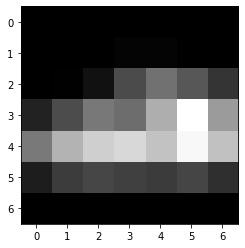

output :


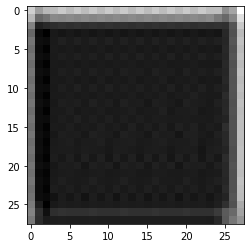

target :


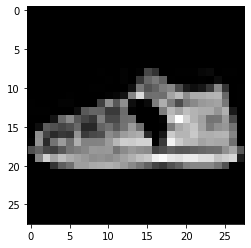


Super Resolution Average supervised loss: 1.145911
Super Resolution Average MSE loss: 0.169725

Train Epoch: 0 [    0/60000 (0%)]	Loss: 1.168614
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.104292
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.063603
input :


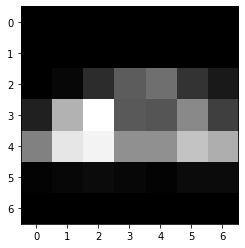

output :


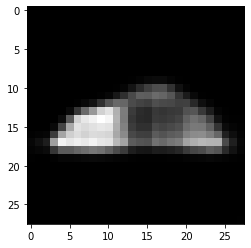

target :


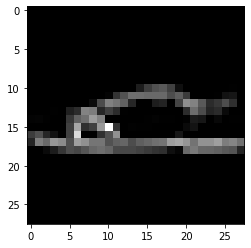


Super Resolution Average supervised loss: 0.085493
Super Resolution Average MSE loss: 0.017115

Train Epoch: 1 [    0/60000 (0%)]	Loss: 0.078883
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.087790
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.080993
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.065888
input :


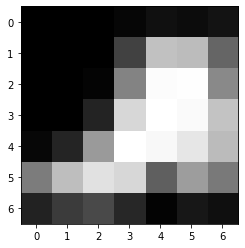

output :


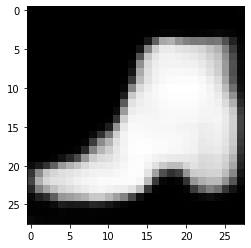

target :


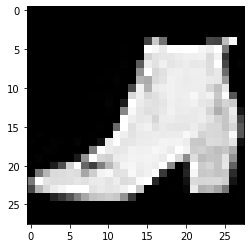


Super Resolution Average supervised loss: 0.124405
Super Resolution Average MSE loss: 0.015024

Train Epoch: 2 [    0/60000 (0%)]	Loss: 0.112672
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.093096
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.136028
Train Epoch: 2 [44928/60000 (100%)]	Loss: 0.114356
input :


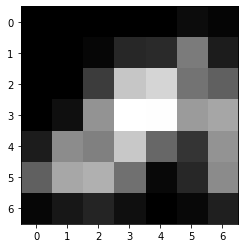

output :


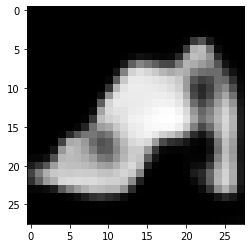

target :


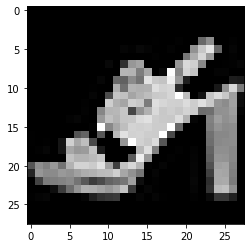


Super Resolution Average supervised loss: 0.210186
Super Resolution Average MSE loss: 0.014294

Train Epoch: 3 [    0/60000 (0%)]	Loss: 0.275980
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.220378
Train Epoch: 3 [39936/60000 (66%)]	Loss: 0.185847
Train Epoch: 3 [22464/60000 (100%)]	Loss: 0.071633
input :


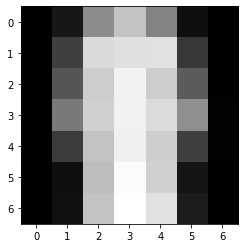

output :


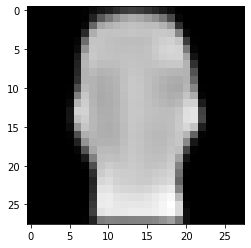

target :


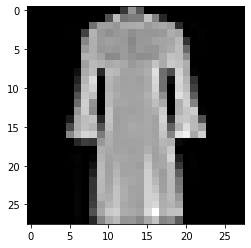


Super Resolution Average supervised loss: 0.383205
Super Resolution Average MSE loss: 0.013954

Train Epoch: 4 [    0/60000 (0%)]	Loss: 0.392947
Train Epoch: 4 [19968/60000 (33%)]	Loss: 0.412172
Train Epoch: 4 [39936/60000 (66%)]	Loss: 0.396452
Train Epoch: 4 [11232/60000 (99%)]	Loss: 0.103083
input :


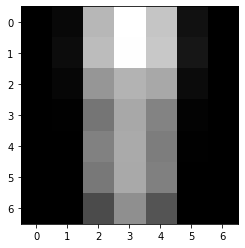

output :


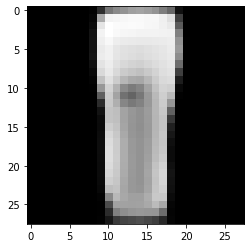

target :


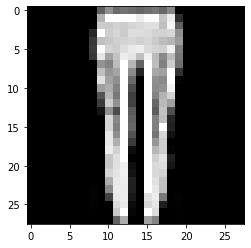


Super Resolution Average supervised loss: 0.746071
Super Resolution Average MSE loss: 0.013775

Train Epoch: 5 [    0/60000 (0%)]	Loss: 0.841705
Train Epoch: 5 [19456/60000 (32%)]	Loss: 0.822350
Train Epoch: 5 [38912/60000 (64%)]	Loss: 0.779442
Train Epoch: 5 [35264/60000 (98%)]	Loss: 0.458594
input :


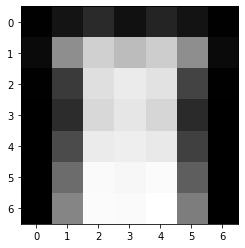

output :


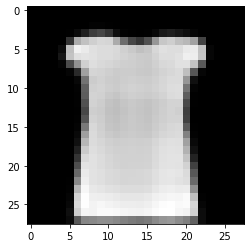

target :


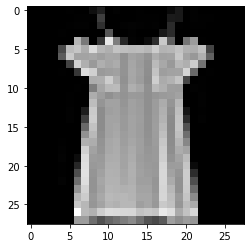


Super Resolution Average supervised loss: 0.740936
Super Resolution Average MSE loss: 0.013709

Train Epoch: 6 [    0/60000 (0%)]	Loss: 0.791736
Train Epoch: 6 [19456/60000 (32%)]	Loss: 0.759530
Train Epoch: 6 [38912/60000 (64%)]	Loss: 0.843480
Train Epoch: 6 [35264/60000 (98%)]	Loss: 0.475767
input :


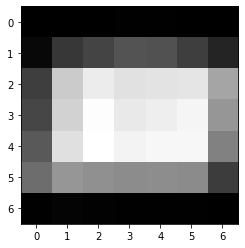

output :


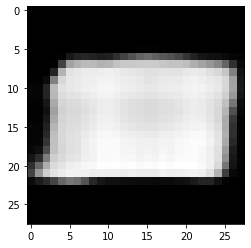

target :


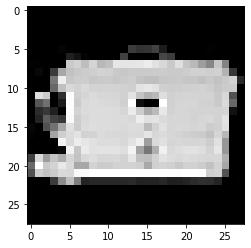


Super Resolution Average supervised loss: 0.735807
Super Resolution Average MSE loss: 0.013658

Train Epoch: 7 [    0/60000 (0%)]	Loss: 0.743002
Train Epoch: 7 [19456/60000 (32%)]	Loss: 0.858082
Train Epoch: 7 [38912/60000 (64%)]	Loss: 0.806344
Train Epoch: 7 [35264/60000 (98%)]	Loss: 0.486635
input :


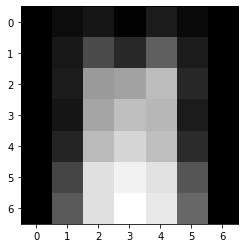

output :


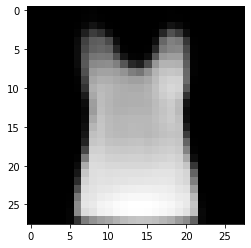

target :


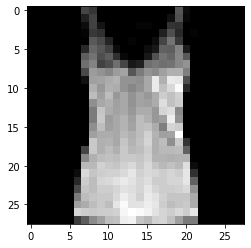


Super Resolution Average supervised loss: 0.741442
Super Resolution Average MSE loss: 0.013628

Train Epoch: 8 [    0/60000 (0%)]	Loss: 0.806583
Train Epoch: 8 [19456/60000 (32%)]	Loss: 0.726023
Train Epoch: 8 [38912/60000 (64%)]	Loss: 0.821216
Train Epoch: 8 [35264/60000 (98%)]	Loss: 0.517254
input :


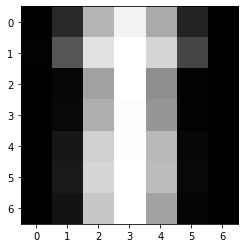

output :


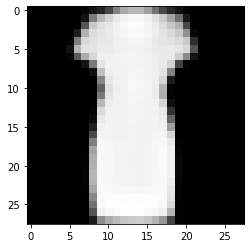

target :


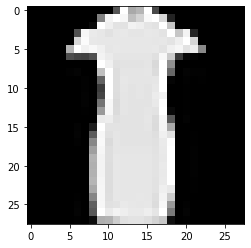


Super Resolution Average supervised loss: 0.721584
Super Resolution Average MSE loss: 0.013545

Train Epoch: 9 [    0/60000 (0%)]	Loss: 0.772182
Train Epoch: 9 [19456/60000 (32%)]	Loss: 0.769263
Train Epoch: 9 [38912/60000 (64%)]	Loss: 0.723160
Train Epoch: 9 [35264/60000 (98%)]	Loss: 0.416523
input : torch.Size([1, 1, 28, 28])


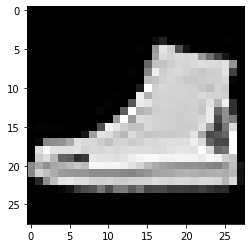

output : torch.Size([1, 1, 112, 112])


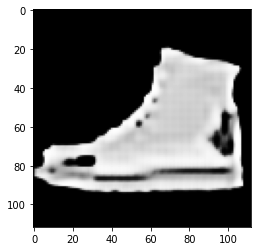

label :  tensor(9)  classifier output :  tensor(9, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


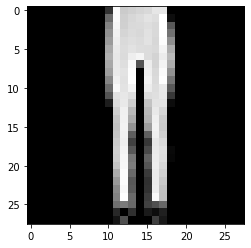

output : torch.Size([1, 1, 112, 112])


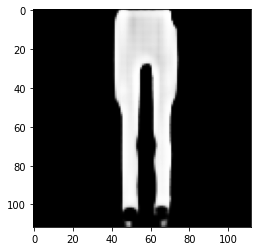

label :  tensor(1)  classifier output :  tensor(1, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


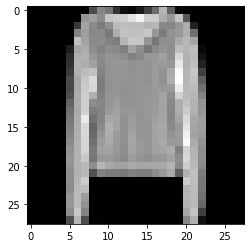

output : torch.Size([1, 1, 112, 112])


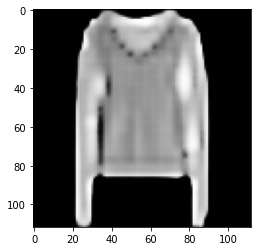

label :  tensor(2)  classifier output :  tensor(2, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


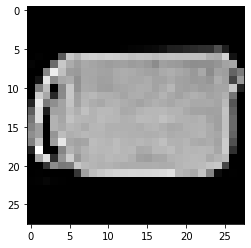

output : torch.Size([1, 1, 112, 112])


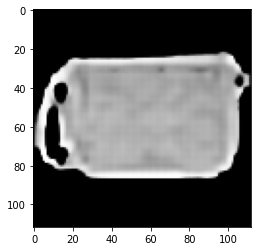

label :  tensor(8)  classifier output :  tensor(8, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


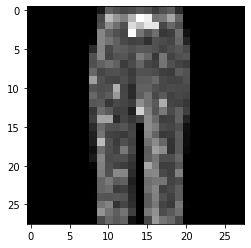

output : torch.Size([1, 1, 112, 112])


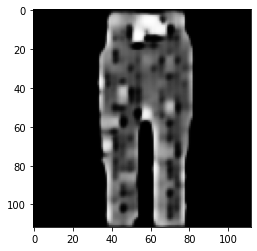

label :  tensor(1)  classifier output :  tensor(1, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


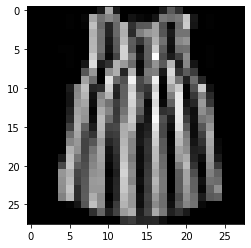

output : torch.Size([1, 1, 112, 112])


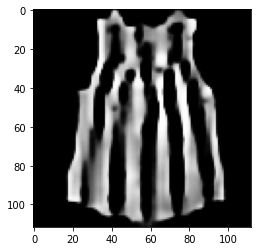

label :  tensor(6)  classifier output :  tensor(6, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


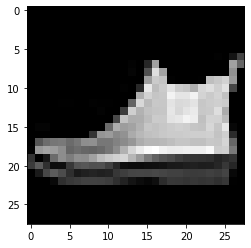

output : torch.Size([1, 1, 112, 112])


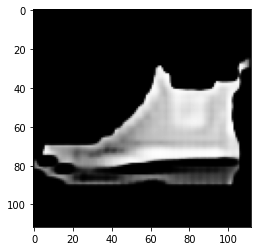

label :  tensor(9)  classifier output :  tensor(7, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


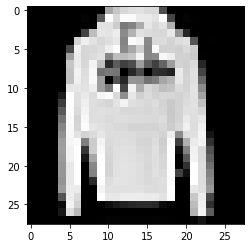

output : torch.Size([1, 1, 112, 112])


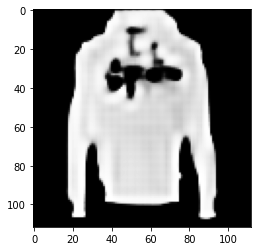

label :  tensor(2)  classifier output :  tensor(2, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


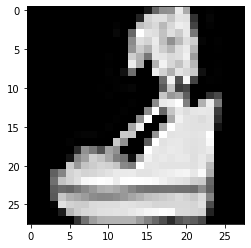

output : torch.Size([1, 1, 112, 112])


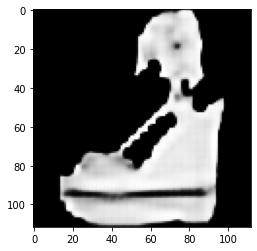

label :  tensor(5)  classifier output :  tensor(5, device='cuda:0')
input : torch.Size([1, 1, 28, 28])


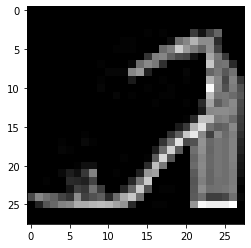

output : torch.Size([1, 1, 112, 112])


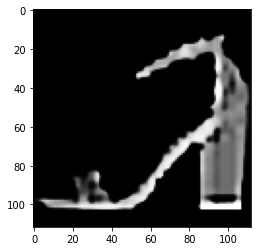

label :  tensor(5)  classifier output :  tensor(5, device='cuda:0')


In [ ]:
main(FashionMNIST_train, FashionMNIST_test, 10)